# Twin4Build: Parameter Estimation Example

This notebook demonstrates how to perform parameter estimation on a building model using Twin4Build. You'll learn how to:
1. Load a pre-built model from a semantic file
2. Set up simulation parameters and time periods
3. Define target parameters for estimation
4. Configure measuring devices for calibration
5. Run parameter estimation using automatic differentiation
6. Visualize and compare results before and after calibration

This example is particularly useful for understanding:
- How to calibrate building models with real data
- Parameter estimation techniques in building simulation
- Model validation and verification
- Automatic differentiation for gradient-based optimization
- Thermal and mass balance parameter calibration

## 1. Setup
First, let's install and import the necessary packages. If you're running this in Google Colab, uncomment the pip install line.

In [1]:
import sys
sys.path.append(r"C:\Users\jabj\Documents\python\Twin4Build")

import twin4build as tb
import datetime
from dateutil import tz
import twin4build.examples.utils as utils

## 2. Load the Model

We'll load a pre-built model from a semantic file. This model contains a building space with various components including:
- Building space with thermal and mass parameters
- Space heater for heating
- Temperature and CO2 controllers
- Valves and dampers for control
- Various sensors for measurement

In [2]:
# Create a new model
model = tb.Model(id="building_space_with_space_heater_model")

# Load the model from semantic file
filename_simulation = utils.get_path(["generated_files", "models", "translator_example", "simulation_model", "semantic_model", "semantic_model.ttl"])
model.load(simulation_model_filename=filename_simulation, verbose=False)
print(model)


Loading model...[OK]
   |___Loading simulation model...[OK]
   |   |
   |   |___Loading model from RDF file...[OK]
   |   |___Removing cycles...[OK]
   |   |___Determining execution order...[OK]
   |   |___Loading parameters...[OK]
   |   |   |
   |   |
   |   |___Validating model...[WARNING]
   |   |   |
   |   |   |___|CLASS: BuildingSpaceTorchSystem|ID: 020B|: Missing connections for the following input(s) to enable use of Simulator, Estimator, and Optimizer:
   |   |   |   |
   |   |   |   |___adjacentZoneTemperature
   |   |   |
   |   |   |___|CLASS: SensorSystem|ID: BTA004|: Missing connections for the following input(s) to enable use of Simulator, Estimator, and Optimizer:
   |   |   |   |
   |   |   |   |___measuredValue
   |   |   |
   |   |
   |   |___Validated for Simulator...FAILED
   |   |___Validated for Estimator...FAILED
   |   |___Validated for Optimizer...FAILED
   |   |___
   |
   |___Drawing simulation model...
[OK]

Model loaded...+-------------------------------

## 3. Set Up Simulation Parameters

Define the simulation time period and step size. We'll simulate for several days to capture different operating conditions.

In [3]:
# Set up simulation parameters
simulator = tb.Simulator(model)
stepSize = 1200  # 20 minutes in seconds
startTime = datetime.datetime(year=2023, month=11, day=27, hour=0, minute=0, second=0,
                                tzinfo=tz.gettz("Europe/Copenhagen"))
endTime = datetime.datetime(year=2023, month=12, day=1, hour=0, minute=0, second=0,
                            tzinfo=tz.gettz("Europe/Copenhagen"))

print(f"Simulation period: {startTime} to {endTime}")
print(f"Step size: {stepSize} seconds ({stepSize/60:.1f} minutes)")


Simulation period: 2023-11-27 00:00:00+01:00 to 2023-12-01 00:00:00+01:00
Step size: 1200 seconds (20.0 minutes)


## 4. Identify Model Components

Let's identify the key components in our model that we'll be working with for parameter estimation.

In [4]:
# Get references to key components
space = model.components["020B"]
space_heater = model.components["020B_space_heater"]
heating_controller = model.components["020B_temperature_heating_controller"]
co2_controller = model.components["020B_co2_controller"]
space_heater_valve = model.components["020B_space_heater_valve"]
supply_damper = model.components["020B_room_supply_damper"]
exhaust_damper = model.components["020B_room_exhaust_damper"]

print("Key components identified:")
print(f"- Building space: {space.id}")
print(f"- Space heater: {space_heater.id}")
print(f"- Heating controller: {heating_controller.id}")
print(f"- CO2 controller: {co2_controller.id}")
print(f"- Space heater valve: {space_heater_valve.id}")
print(f"- Supply damper: {supply_damper.id}")
print(f"- Exhaust damper: {exhaust_damper.id}")

Key components identified:
- Building space: 020B
- Space heater: 020B_space_heater
- Heating controller: 020B_temperature_heating_controller
- CO2 controller: 020B_co2_controller
- Space heater valve: 020B_space_heater_valve
- Supply damper: 020B_room_supply_damper
- Exhaust damper: 020B_room_exhaust_damper


## 5. Define Target Parameters for Estimation

We'll define the parameters we want to estimate. These include:
- Thermal parameters (capacitances, resistances, radiation factors)
- Mass parameters (volume, CO2 generation, infiltration)
- Space heater parameters (thermal mass, conductance)
- Controller parameters (PID gains)
- Valve and damper parameters (flow rates, authority)

Each parameter has initial values, lower bounds, and upper bounds.

In [5]:
targetParameters = {"private": {
    # Thermal parameters
    "thermal.C_air": {"components": [space], "x0": 2e+6, "lb": 1e+6, "ub": 1e+7},                # Thermal capacitance of indoor air [J/K]
    "thermal.C_wall": {"components": [space], "x0": 2e+6, "lb": 1e+6, "ub": 1e+7},               # Thermal capacitance of exterior wall [J/K]
    "thermal.C_boundary": {"components": [space], "x0": 5e+5, "lb": 1e+4, "ub": 1e+6},               # Thermal capacitance of exterior wall [J/K]
    "thermal.R_out": {"components": [space], "x0": 0.05, "lb": 0.01, "ub": 1},                # Thermal resistance between wall and outdoor [K/W]
    "thermal.R_in": {"components": [space], "x0": 0.05, "lb": 0.01, "ub": 1},                 # Thermal resistance between wall and indoor [K/W]
    "thermal.R_boundary": {"components": [space], "x0": 0.01, "lb": 0.0001, "ub": 1},                 # Thermal resistance between wall and indoor [K/W]
    "thermal.f_wall": {"components": [space], "x0": 0.3, "lb": 0, "ub": 1},         # Radiation factor for exterior wall
    "thermal.f_air": {"components": [space], "x0": 0.1, "lb": 0, "ub": 1},          # Radiation factor for air
    "thermal.Q_occ_gain": {"components": [space], "x0": 100.0, "lb": 10, "ub": 200},   # Heat gain per occupant [W]

    # Mass parameters
    "mass.V": {"components": [space], "x0": 100, "lb": 10, "ub": 1000}, # Volume of the space [m³]
    "mass.G_occ": {"components": [space], "x0": 8.18e-6, "lb": 1e-8, "ub": 1e-4}, # CO2 generation rate per occupant [ppm·kg/s]
    "mass.m_inf": {"components": [space], "x0": 0.001, "lb": 1e-6, "ub": 0.3}, # Infiltration rate [kg/s]

    # Space heater parameters
    "thermalMassHeatCapacity": {"components": [space_heater], "x0": 10000, "lb": 1000, "ub": 50000}, # Thermal mass heat capacity [J/K]
    "UA": {"components": [space_heater], "x0": 30, "lb": 1, "ub": 100}, # Thermal conductance [W/K]

    # Heating controller parameters
    "kp": {"components": [heating_controller, co2_controller], "x0": [0.001, -0.001], "lb": [1e-5, -1], "ub": [1, -1e-5]}, # Proportional gain
    "Ti": {"components": [heating_controller, co2_controller], "x0": [10, 10], "lb": [1, 1], "ub": [100, 100]}, # Integral gain
    "Td": {"components": [heating_controller, co2_controller], "x0": [0, 0], "lb": [0, 0], "ub": [1, 1]}, # Derivative gain

    # Space heater valve parameters
    "waterFlowRateMax": {"components": [space_heater_valve], "x0": 0.01, "lb": 1e-6, "ub": 0.1}, # Maximum water flow rate [m³/s]
    "valveAuthority": {"components": [space_heater_valve], "x0": 0.8, "lb": 0.4, "ub": 1}, # Valve authority

    # Damper parameters
    "a": {"components": [supply_damper, exhaust_damper], "x0": 1, "lb": 1, "ub": 10}, # Shape parameter
    "nominalAirFlowRate": {"components": [supply_damper, exhaust_damper], "x0": 0.001, "lb": 1e-5, "ub": 1}, # Maximum water flow rate [m³/s]
}}

print(f"Defined {len(targetParameters['private'])} parameters for estimation")
print("\nParameter categories:")
categories = {
    "Thermal": [k for k in targetParameters['private'].keys() if k.startswith('thermal.')],
    "Mass": [k for k in targetParameters['private'].keys() if k.startswith('mass.')],
    "Space Heater": [k for k in targetParameters['private'].keys() if k in ['thermalMassHeatCapacity', 'UA']],
    "Controllers": [k for k in targetParameters['private'].keys() if k in ['kp', 'Ti', 'Td']],
    "Valve": [k for k in targetParameters['private'].keys() if k in ['waterFlowRateMax', 'valveAuthority']],
    "Dampers": [k for k in targetParameters['private'].keys() if k in ['a', 'nominalAirFlowRate']]
}
for category, params in categories.items():
    print(f"- {category}: {len(params)} parameters")

Defined 21 parameters for estimation

Parameter categories:
- Thermal: 9 parameters
- Mass: 3 parameters
- Space Heater: 2 parameters
- Controllers: 3 parameters
- Valve: 2 parameters
- Dampers: 2 parameters


## 6. Configure Measuring Devices

Define the sensors that will provide measurement data for calibration. These sensors measure:
- Valve position
- Indoor temperature
- CO2 concentration
- Damper position

In [6]:
targetMeasuringDevices = [
    model.components["020B_valve_position_sensor"],
    model.components["020B_temperature_sensor"],
    model.components["020B_co2_sensor"],
    model.components["020B_damper_position_sensor"]
]

print("Measuring devices for calibration:")
for device in targetMeasuringDevices:
    print(f"- {device.id}")

Measuring devices for calibration:
- 020B_valve_position_sensor
- 020B_temperature_sensor
- 020B_co2_sensor
- 020B_damper_position_sensor


## 7. Run Initial Simulation

Before parameter estimation, let's run a simulation with the initial parameter values to see how well the model performs.

In [7]:
# Run initial simulation for comparison
simulator.simulate(
    stepSize=stepSize,
    startTime=startTime,
    endTime=endTime
)

print("Initial simulation completed successfully!")

100%|██████████| 288/288 [00:01<00:00, 278.71it/s]

Initial simulation completed successfully!


## 8. Plot Initial Results

Let's visualize the initial simulation results to understand the model behavior before calibration.

Initial simulation plots generated.


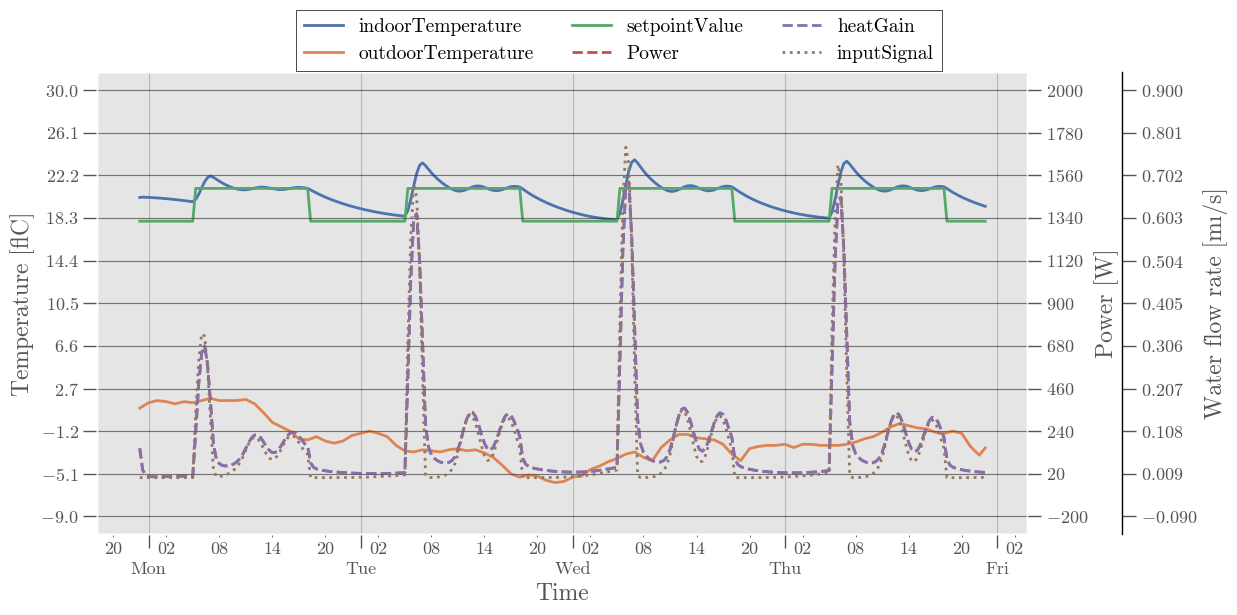

In [8]:
# Plot initial results
fig, axes = tb.plot.plot_component(
    simulator,
    components_1axis=[
        ("020B", "indoorTemperature", "output"),
        ("outdoor_environment", "outdoorTemperature", "output"),
        (heating_controller.id, "setpointValue", "input"),
    ],
    components_2axis=[
        ("020B_space_heater", "Power", "output"),
        ("020B", "heatGain", "input"),
    ],
    components_3axis=[
        (heating_controller.id, "inputSignal", "output"),
    ],
    ylabel_1axis="Temperature [°C]",
    ylabel_2axis="Power [W]",
    ylabel_3axis="Water flow rate [m³/s]",
    title="Before calibration",
    show=False,
    nticks=11
)

print("Initial simulation plots generated.")

## 9. Create and Configure Estimator

Now we'll create an estimator instance and configure it for parameter estimation using automatic differentiation.

In [9]:
# Create estimator
estimator = tb.Estimator(simulator)

# Configure optimization options
options = {} # Just use standard options

print("Estimator created and configured.")
print(f"Optimization options: {options}")

Estimator created and configured.
Optimization options: {}


## 10. Run Parameter Estimation

Now we'll run the parameter estimation using the LS_AD (Least Squares with Automatic Differentiation) method. This method uses automatic differentiation to compute gradients efficiently.

In [10]:
# Run parameter estimation
estimator.estimate(
        targetParameters=targetParameters,
        targetMeasuringDevices=targetMeasuringDevices,
        startTime=startTime,
        endTime=endTime,
        stepSize=stepSize,
        n_initialization_steps=20,
        method=("scipy", "SLSQP", "ad"),
        options=options,
    )


{'result_x': array([2.46122768e-03, 3.42796321e-01, 3.52666375e-01, 6.53262990e-02,
        4.73097278e-04, 1.77290319e-03, 2.85802972e-01, 9.80418813e-02,
        4.73684211e-01, 9.35104976e-01, 8.17081708e-02, 5.10244028e-15,
        9.12258056e-02, 5.21308845e-01, 1.57154029e-04, 9.99009990e-01,
        4.52698687e-04, 9.09090909e-02, 2.70707930e-07, 0.00000000e+00,
        3.23173345e-02, 8.23992975e-01, 0.00000000e+00, 0.00000000e+00,
        9.90009900e-04, 9.90009900e-04]),
 'component_id': ['020B',
  '020B',
  '020B',
  '020B',
  '020B',
  '020B',
  '020B',
  '020B',
  '020B',
  '020B',
  '020B',
  '020B',
  '020B_space_heater',
  '020B_space_heater',
  '020B_temperature_heating_controller',
  '020B_co2_controller',
  '020B_temperature_heating_controller',
  '020B_co2_controller',
  '020B_temperature_heating_controller',
  '020B_co2_controller',
  '020B_space_heater_valve',
  '020B_space_heater_valve',
  '020B_room_supply_damper',
  '020B_room_exhaust_damper',
  '020B_room_supp

## 11. Plot Calibrated Results

Let's visualize the results after parameter calibration to see the improvement in model performance.

Calibrated simulation plots generated.


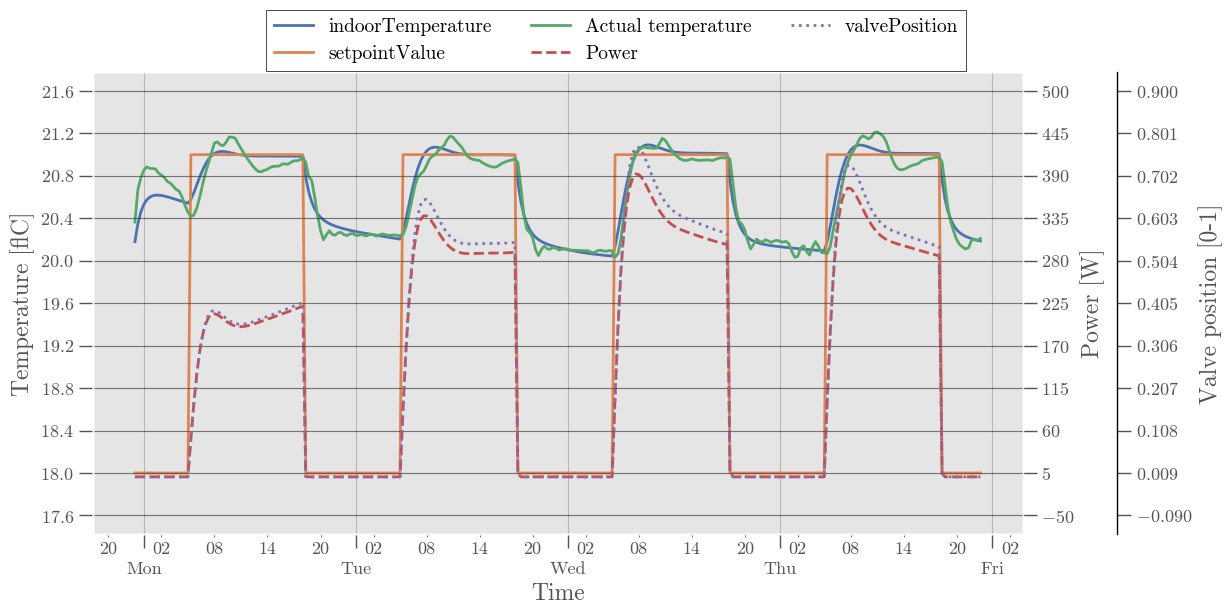

In [11]:
# Plot results after calibration
fig, axes = tb.plot.plot_component(
    simulator,
    components_1axis=[
        ("020B", "indoorTemperature", "output"),
        (heating_controller.id, "setpointValue", "input"),
        (estimator.actual_readings[model.components["020B_temperature_sensor"].id], "Actual temperature"),
    ],
    components_2axis=[
        ("020B_space_heater", "Power", "output"),
    ],
    components_3axis=[
        ("020B_space_heater_valve", "valvePosition", "output"),
    ],
    ylabel_1axis="Temperature [°C]",
    ylabel_2axis="Power [W]",
    ylabel_3axis="Valve position [0-1]",
    title="After calibration",
    show=False,
    nticks=11
)

print("Calibrated simulation plots generated.")

## 12. Compare Valve Position

Let's specifically compare the valve position measurements to see how well the model matches the actual data.

Valve position comparison plot generated.


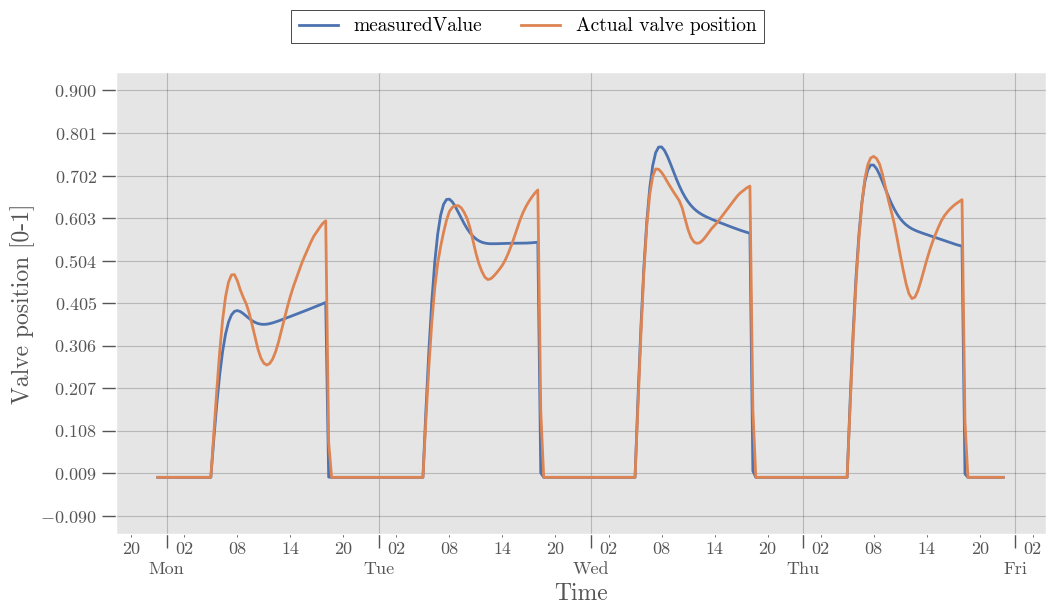

In [12]:
# Plot valve position comparison
fig, axes = tb.plot.plot_component(
    simulator,
    components_1axis=[
        ("020B_valve_position_sensor", "measuredValue", "input"),
        (estimator.actual_readings[model.components["020B_valve_position_sensor"].id], "Actual valve position"),
    ],
    ylabel_1axis="Valve position [0-1]",
    title="Valve position comparison",
    show=False,
    nticks=11
)

print("Valve position comparison plot generated.")

## 13. Compare Temperature Measurements

Finally, let's compare the temperature measurements to see the improvement in model accuracy.

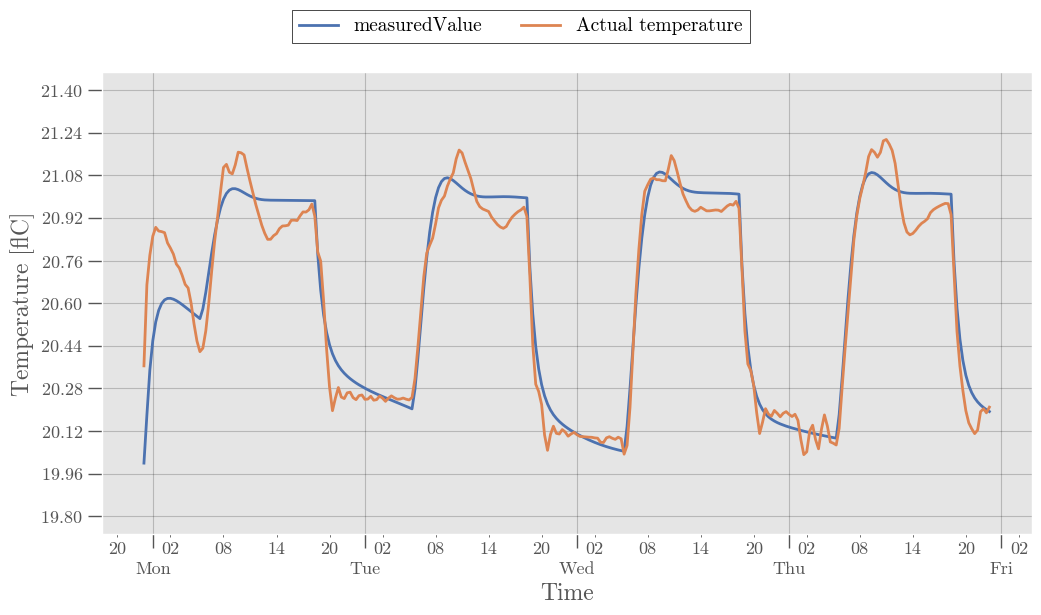

Temperature comparison plot generated.

Parameter estimation example completed successfully!


In [13]:
# Plot temperature comparison
fig, axes = tb.plot.plot_component(
    simulator,
    components_1axis=[
        ("020B_temperature_sensor", "measuredValue", "input"),
        (estimator.actual_readings[model.components["020B_temperature_sensor"].id], "Actual temperature"),
    ],
    ylabel_1axis="Temperature [°C]",
    title="Temperature comparison",
    show=True,
    nticks=11
)

print("Temperature comparison plot generated.")
print("\nParameter estimation example completed successfully!")

## Summary

In this example, we demonstrated how to:

1. **Load a pre-built model** from a semantic file containing building components
2. **Set up simulation parameters** including time period and step size
3. **Define target parameters** for estimation with appropriate bounds
4. **Configure measuring devices** to provide calibration data
5. **Run parameter estimation** using automatic differentiation (LS_AD method)
6. **Visualize results** before and after calibration

The parameter estimation process helps improve the accuracy of building models by calibrating them against real measurement data. This is essential for creating reliable digital twins that can be used for building control optimization, energy analysis, and predictive maintenance.

Key benefits of this approach:
- **Automatic differentiation** provides efficient gradient computation
- **Multiple parameter types** can be estimated simultaneously
- **Bounded optimization** ensures physically realistic parameter values
- **Visual comparison** helps validate the calibration results